In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Tensorflow

In [1]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, r'G:\My Drive\DNN')
from collections.abc import Callable
from typing import Literal

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf

from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix

In [2]:
print (fn_plot_tf_hist.__doc__)


    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    


In [3]:
print (fn_plot_confusion_matrix.__doc__)


    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    


In [35]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../input'
outDir = '../output'
modelDir = './models'
subDir = 'fifa_2019'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 101 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2
REG_LAMBDA = 0.001

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [5]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))
    print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

Created ./models\fifa_2019 directory


## Read FIFA 2019 data set

In [6]:
data_df = pd.read_csv(os.path.join(inpDir, 'fifa_2019.csv'))
data_df.shape

(18207, 89)

In [8]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 89 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                18207 non-null  int64  
 1   ID                        18207 non-null  int64  
 2   Name                      18207 non-null  object 
 3   Age                       18207 non-null  int64  
 4   Photo                     18207 non-null  object 
 5   Nationality               18207 non-null  object 
 6   Flag                      18207 non-null  object 
 7   Overall                   18207 non-null  int64  
 8   Potential                 18207 non-null  int64  
 9   Club                      17966 non-null  object 
 10  Club Logo                 18207 non-null  object 
 11  Value                     18207 non-null  object 
 12  Wage                      18207 non-null  object 
 13  Special                   18207 non-null  int64  
 14  Prefer

In [9]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,18207.0,9103.000000,5256.052511,0.0,4551.5,9103.0,13654.5,18206.0
ID,18207.0,214298.338606,29965.244204,16.0,200315.5,221759.0,236529.5,246620.0
Age,18207.0,25.122206,4.669943,16.0,21.0,25.0,28.0,45.0
Overall,18207.0,66.238699,6.908930,46.0,62.0,66.0,71.0,94.0
Potential,18207.0,71.307299,6.136496,48.0,67.0,71.0,75.0,95.0
Special,18207.0,1597.809908,272.586016,731.0,1457.0,1635.0,1787.0,2346.0
International Reputation,18159.0,1.113222,0.394031,1.0,1.0,1.0,1.0,5.0
Weak Foot,18159.0,2.947299,0.660456,1.0,3.0,3.0,3.0,5.0
Skill Moves,18159.0,2.361308,0.756164,1.0,2.0,2.0,3.0,5.0
Jersey Number,18147.0,19.546096,15.947765,1.0,8.0,17.0,26.0,99.0


In [10]:
data_df.isna().sum().sum()

76984

In [7]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [12]:
data_df[data_df['Name']=="S. Chhetri"]

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
8605,8605,190939,S. Chhetri,33,https://cdn.sofifa.org/players/4/19/190939.png,India,https://cdn.sofifa.org/flags/159.png,67,67,NaN,...,67.0,30.0,24.0,44.0,10.0,7.0,11.0,9.0,10.0,NaN


In [8]:
# Following columns appear to be relevant for our analysis
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

In [9]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [10]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [11]:
data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,3,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,3,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,2,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [12]:
labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

In [13]:
features_df = data_df.drop('Position', axis=1)
labels_df = data_df['Position'].to_numpy()

In [19]:
features_df.shape

(18147, 33)

In [14]:
# splitting in train ans test datasets
X_train, X_test, y_train, y_test = train_test_split(features_df,
                                     labels_df,
                                     stratify=labels_df,
                                     test_size=TEST_SIZE, 
                                     random_state=RANDOM_STATE)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14517, 33), (3630, 33), (14517,), (3630,))

In [15]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

In [18]:
type(X_train), type(X_test), type(y_train), type(y_test)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [ ]:
# 33, 23, 12, 4, 4

In [24]:
k_init = tf.keras.initializers.GlorotUniform(
    seed=RANDOM_STATE
)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (33,)),
    tf.keras.layers.Dense(33, activation = 'relu', kernel_initializer = k_init), 
    tf.keras.layers.Dense(23, activation = 'relu', kernel_initializer = k_init),
    tf.keras.layers.Dense(12, activation = 'relu', kernel_initializer = k_init),
    tf.keras.layers.Dense(4, activation = 'relu', kernel_initializer = k_init),
    tf.keras.layers.Dense(4)
    ])

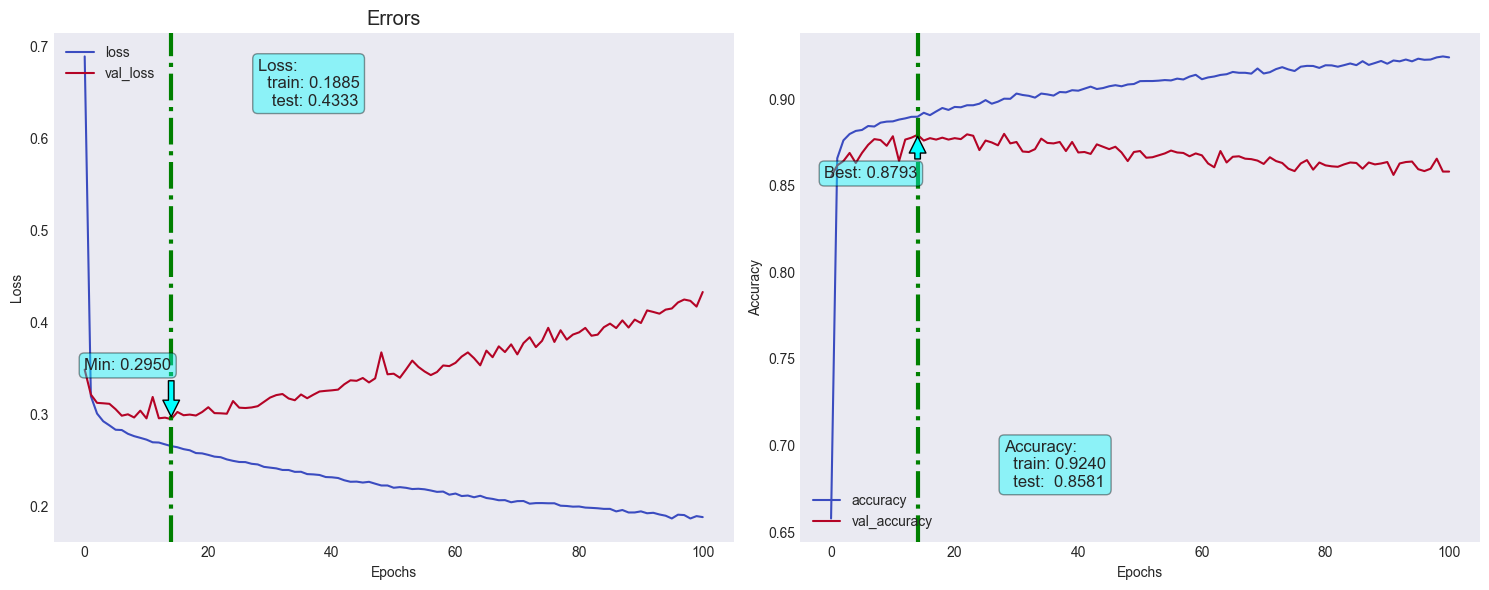

In [30]:
# L2
k_init = tf.keras.initializers.GlorotUniform(
    seed=RANDOM_STATE
)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (33,)),
    tf.keras.layers.Dense(33, activation = 'relu',
                           kernel_initializer = k_init,
                           kernel_regularizer = 'l2'), 

    tf.keras.layers.Dense(23, activation = 'relu', 
                          kernel_initializer = k_init,
                           kernel_regularizer = 'l2'),
    tf.keras.layers.Dense(12, activation = 'relu', 
                          kernel_initializer = k_init,
                           kernel_regularizer = 'l2'),
                           
    tf.keras.layers.Dense(4, activation = 'relu', kernel_initializer = k_init,
                           kernel_regularizer = 'l2'),
    tf.keras.layers.Dense(4)
    ])

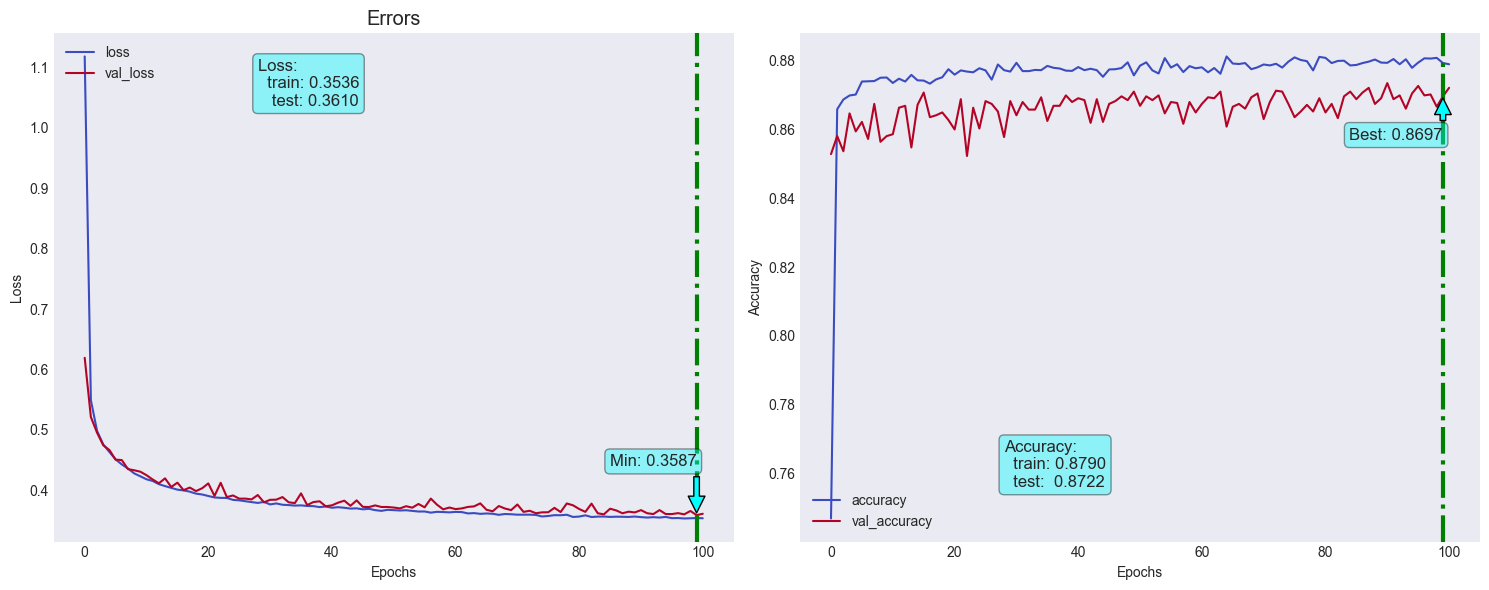

In [37]:
# L2
k_init = tf.keras.initializers.GlorotUniform(
    seed=RANDOM_STATE
)
k_reg = tf.keras.regularizers.L2(l2=REG_LAMBDA)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (33,)),
    tf.keras.layers.Dense(33, activation = 'relu',
                           kernel_initializer = k_init,
                           kernel_regularizer = k_reg), 

    tf.keras.layers.Dense(23, activation = 'relu', 
                          kernel_initializer = k_init,
                           kernel_regularizer = k_reg),
    tf.keras.layers.Dense(12, activation = 'relu', 
                          kernel_initializer = k_init,
                           kernel_regularizer = k_reg),
                           
    tf.keras.layers.Dense(4, activation = 'relu', kernel_initializer = k_init,
                           kernel_regularizer = k_reg),
    tf.keras.layers.Dense(4)
    ])

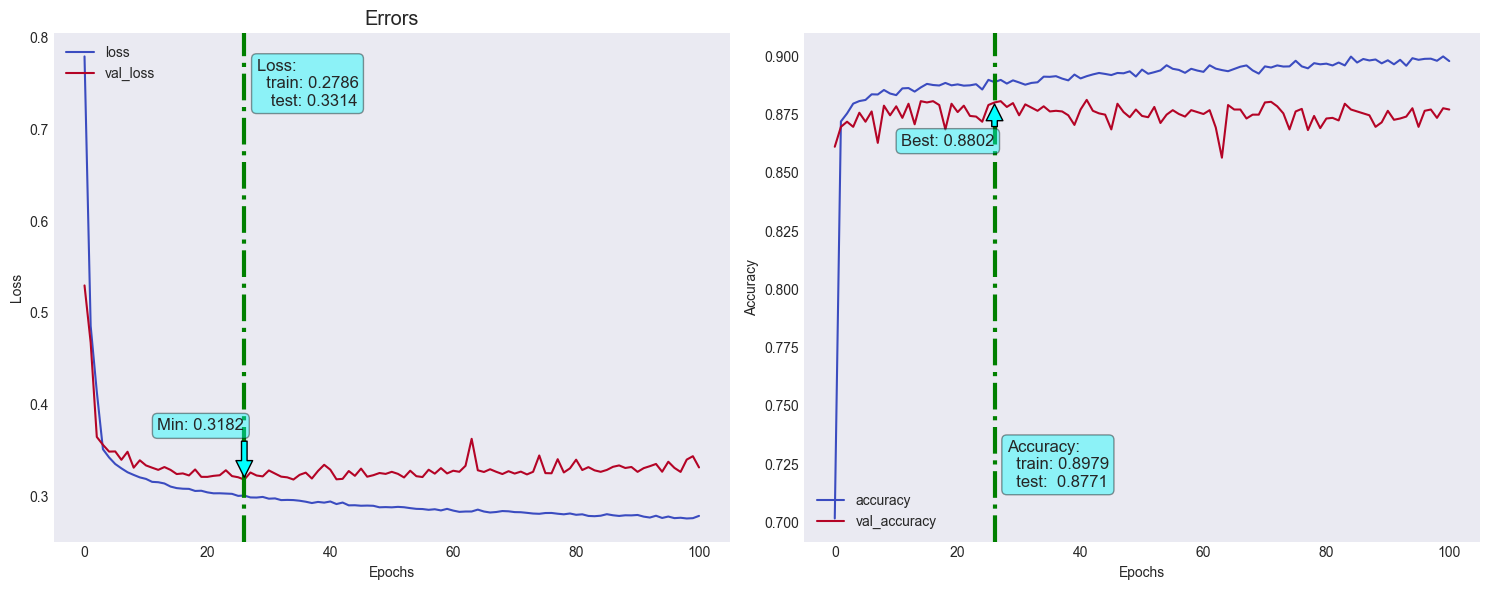

In [38]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True)

optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)

In [39]:
model.compile(optimizer= optimizer, loss=loss_fn, metrics= ['accuracy'])

history = model.fit(X_train, y_train, 
                    validation_data= (X_test, y_test),
                    batch_size= BATCH_SIZE, 
                    epochs=EPOCHS, 
                    verbose= 2)

Epoch 1/101
454/454 - 3s - loss: 0.7794 - accuracy: 0.7017 - val_loss: 0.5298 - val_accuracy: 0.8612 - 3s/epoch - 7ms/step
Epoch 2/101
454/454 - 1s - loss: 0.4856 - accuracy: 0.8720 - val_loss: 0.4676 - val_accuracy: 0.8697 - 1s/epoch - 3ms/step
Epoch 3/101
454/454 - 1s - loss: 0.4139 - accuracy: 0.8755 - val_loss: 0.3647 - val_accuracy: 0.8719 - 1s/epoch - 3ms/step
Epoch 4/101
454/454 - 1s - loss: 0.3513 - accuracy: 0.8797 - val_loss: 0.3561 - val_accuracy: 0.8697 - 1s/epoch - 3ms/step
Epoch 5/101
454/454 - 1s - loss: 0.3423 - accuracy: 0.8808 - val_loss: 0.3487 - val_accuracy: 0.8758 - 1s/epoch - 3ms/step
Epoch 6/101
454/454 - 1s - loss: 0.3352 - accuracy: 0.8812 - val_loss: 0.3489 - val_accuracy: 0.8719 - 1s/epoch - 3ms/step
Epoch 7/101
454/454 - 1s - loss: 0.3304 - accuracy: 0.8837 - val_loss: 0.3397 - val_accuracy: 0.8763 - 1s/epoch - 3ms/step
Epoch 8/101
454/454 - 1s - loss: 0.3262 - accuracy: 0.8836 - val_loss: 0.3485 - val_accuracy: 0.8628 - 1s/epoch - 3ms/step
Epoch 9/101
454/

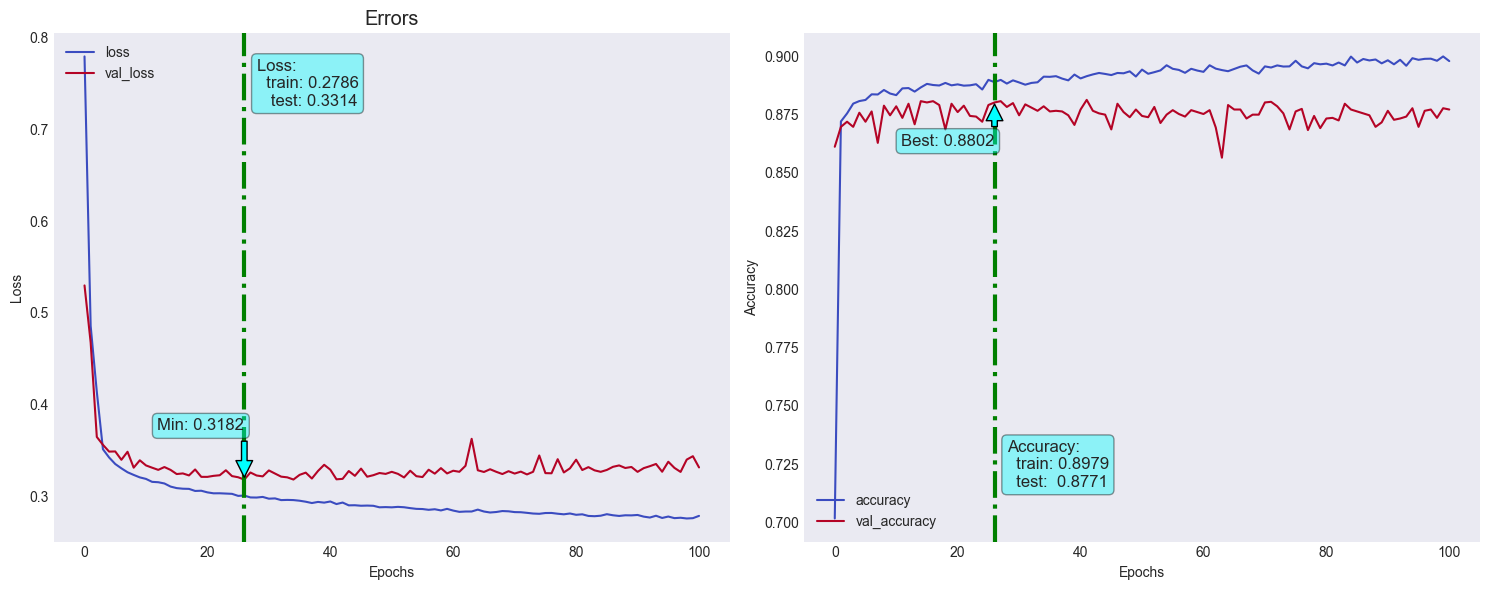

In [40]:
fn_plot_tf_hist(pd.DataFrame(history.history))